# Convolutional Neural Networks

## Load Libraries and Data

In [1]:
# Note: depending on your setup, you may need to
# install scikit-image using the command:
# !pip install scikit-image
# or the terminal command:
# pip install scikit-image

import logging
import io
import requests
import numpy as np
import pandas as pd
from skimage import io
from skimage.util import img_as_float
from sklearn.datasets import load_sample_image
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restrict tensorflow output to errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot formatting
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('axes', grid=False)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
image_urls = [
    'https://raw.githubusercontent.com/natecraig/aiml/main/Data/CNN_Example_Image_A.jpg',
    'https://raw.githubusercontent.com/natecraig/aiml/main/Data/CNN_Example_Image_B.jpg'
]

image_list = []
for url in image_urls:
    image_list.append(io.imread(url))
    
images = np.array(image_list)
batch_size, height, width, channels = images.shape 

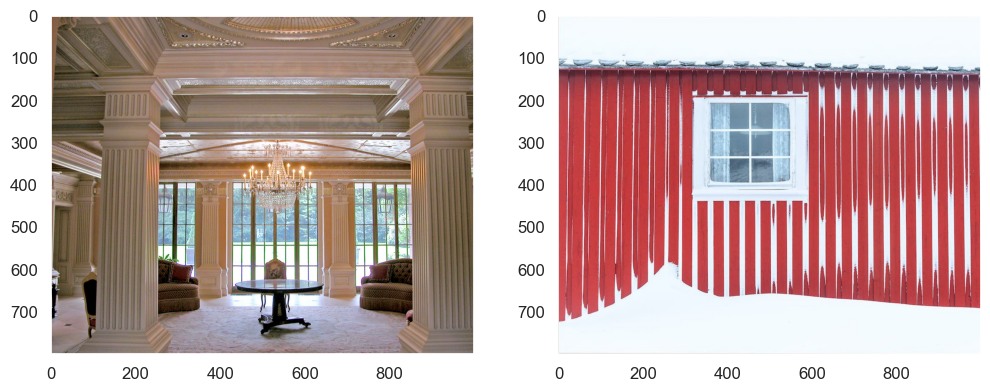

In [3]:
# Display sample images
_, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, im in enumerate(images):
    axs[i].imshow(im)

## Example of Filters and Convolutional Layers

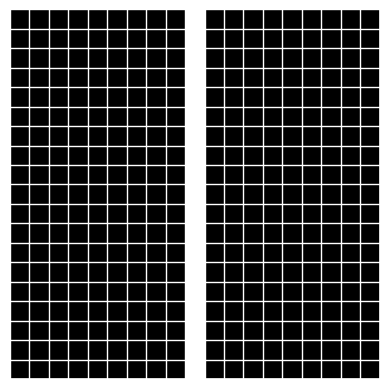

In [4]:
shape = (19, 19, channels, 2)
filters = np.zeros(shape=shape, dtype=np.float32)

# Create a vertical line filter
filters[:, 9, :, 0] = 1

# Plot the filter
fig, ax = plt.subplots()
plt.imshow(filters[:, :, 0, 0], cmap='gray')

# Major ticks
ax.set_xticks(np.arange(-0.5, shape[0] - 0.5, 1))
ax.set_yticks(np.arange(-0.5, shape[1] - 0.5, 1))
plt.grid(True)
ax.tick_params(labelleft=False, labelbottom=False)  
plt.show()

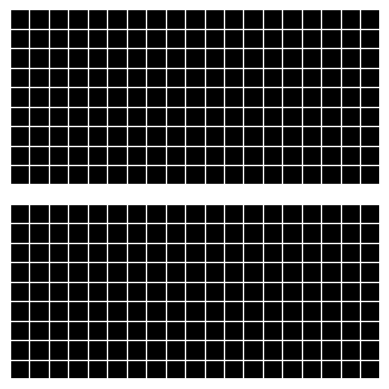

In [5]:
# Create a horizontal line filter
filters[9, :, :, 1] = 1

# Plot the filter
fig, ax = plt.subplots()
plt.imshow(filters[:, :, 0, 1], cmap='gray')

# Major ticks
ax.set_xticks(np.arange(-0.5, shape[0] - 0.5, 1))
ax.set_yticks(np.arange(-0.5, shape[1] - 0.5, 1))
plt.grid(True)
ax.tick_params(labelleft=False, labelbottom=False)  
plt.show()

In [6]:
# Calculate feature maps
outputs = tf.nn.conv2d(tf.cast(images, dtype=tf.float32),
                       filters, strides=1, padding='SAME') 

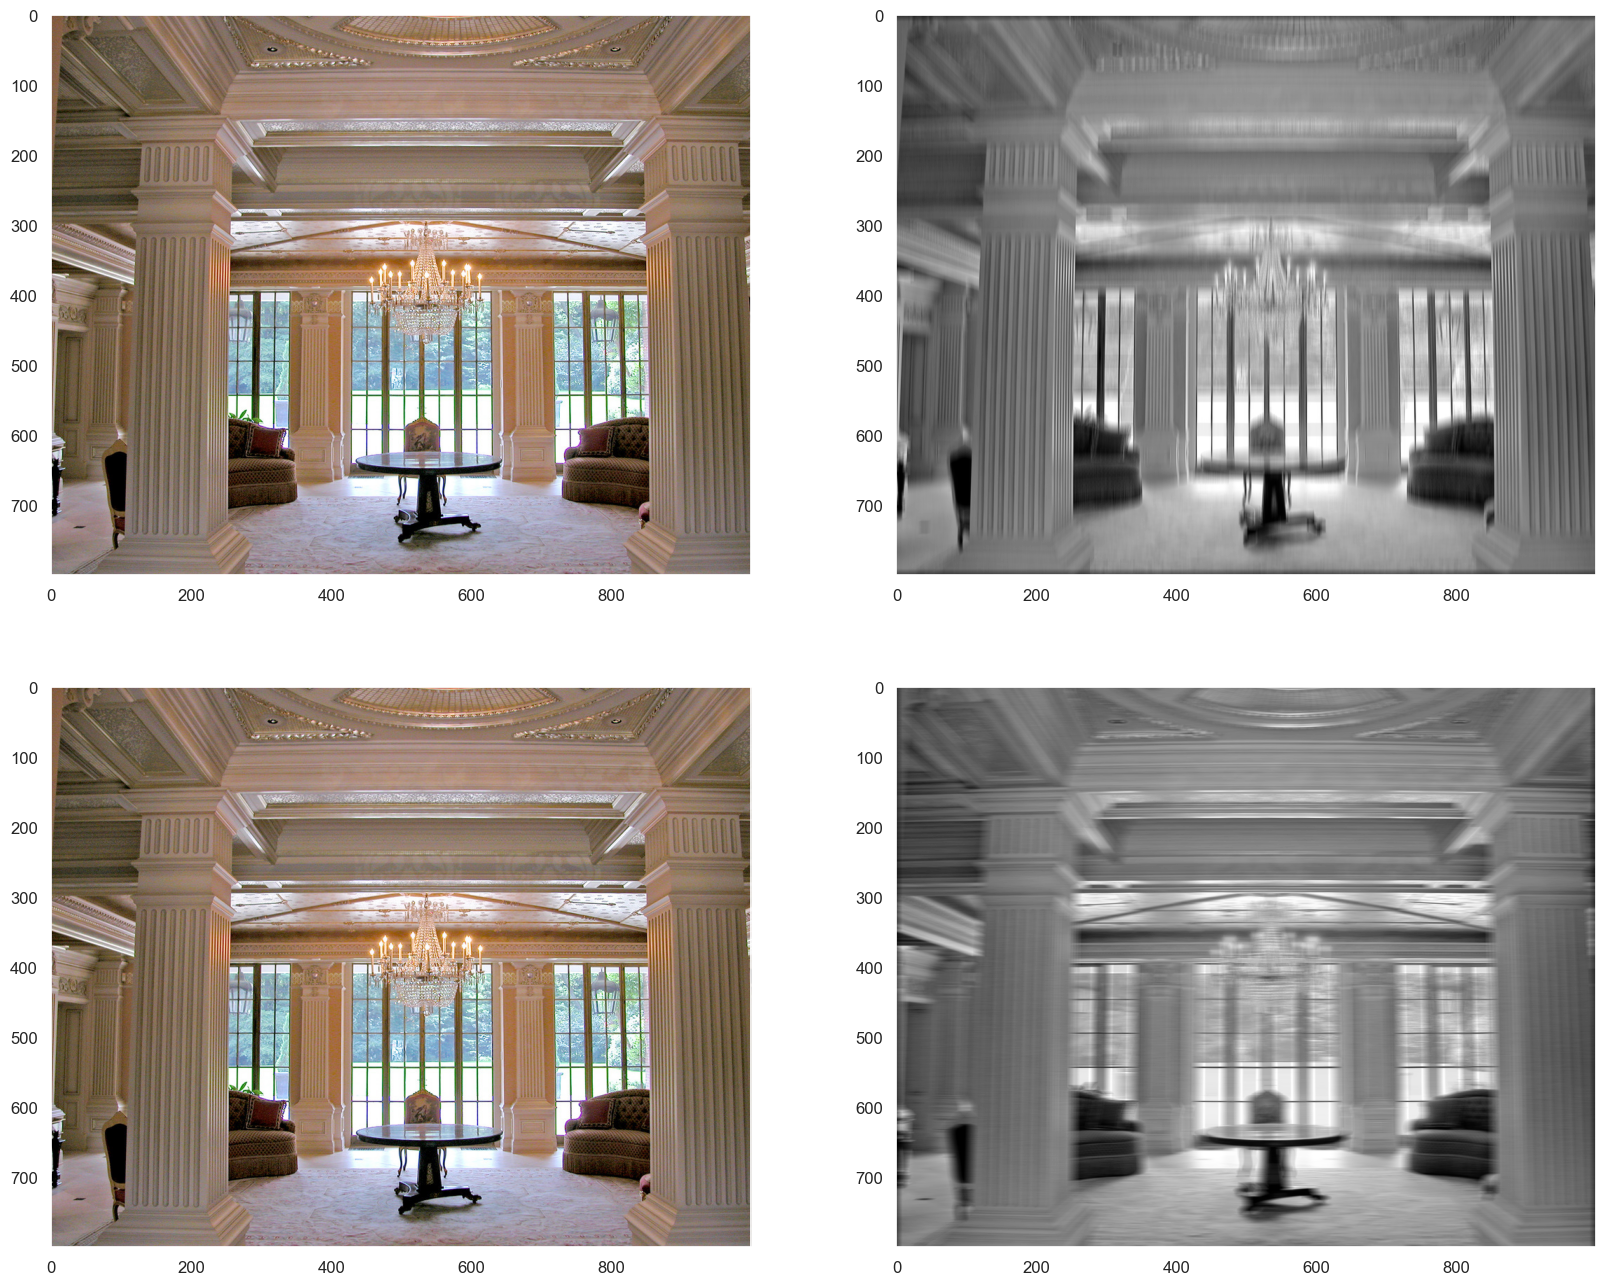

In [7]:
# Plot feature maps for first image
idx = 0
_, axs = plt.subplots(2, 2, figsize=(20, 16))
axs[0, 0].imshow(images[idx])
axs[1, 0].imshow(images[idx])
for i in (0, 1):
    axs[i, 1].imshow(outputs[idx, :, :, i], cmap='gray')

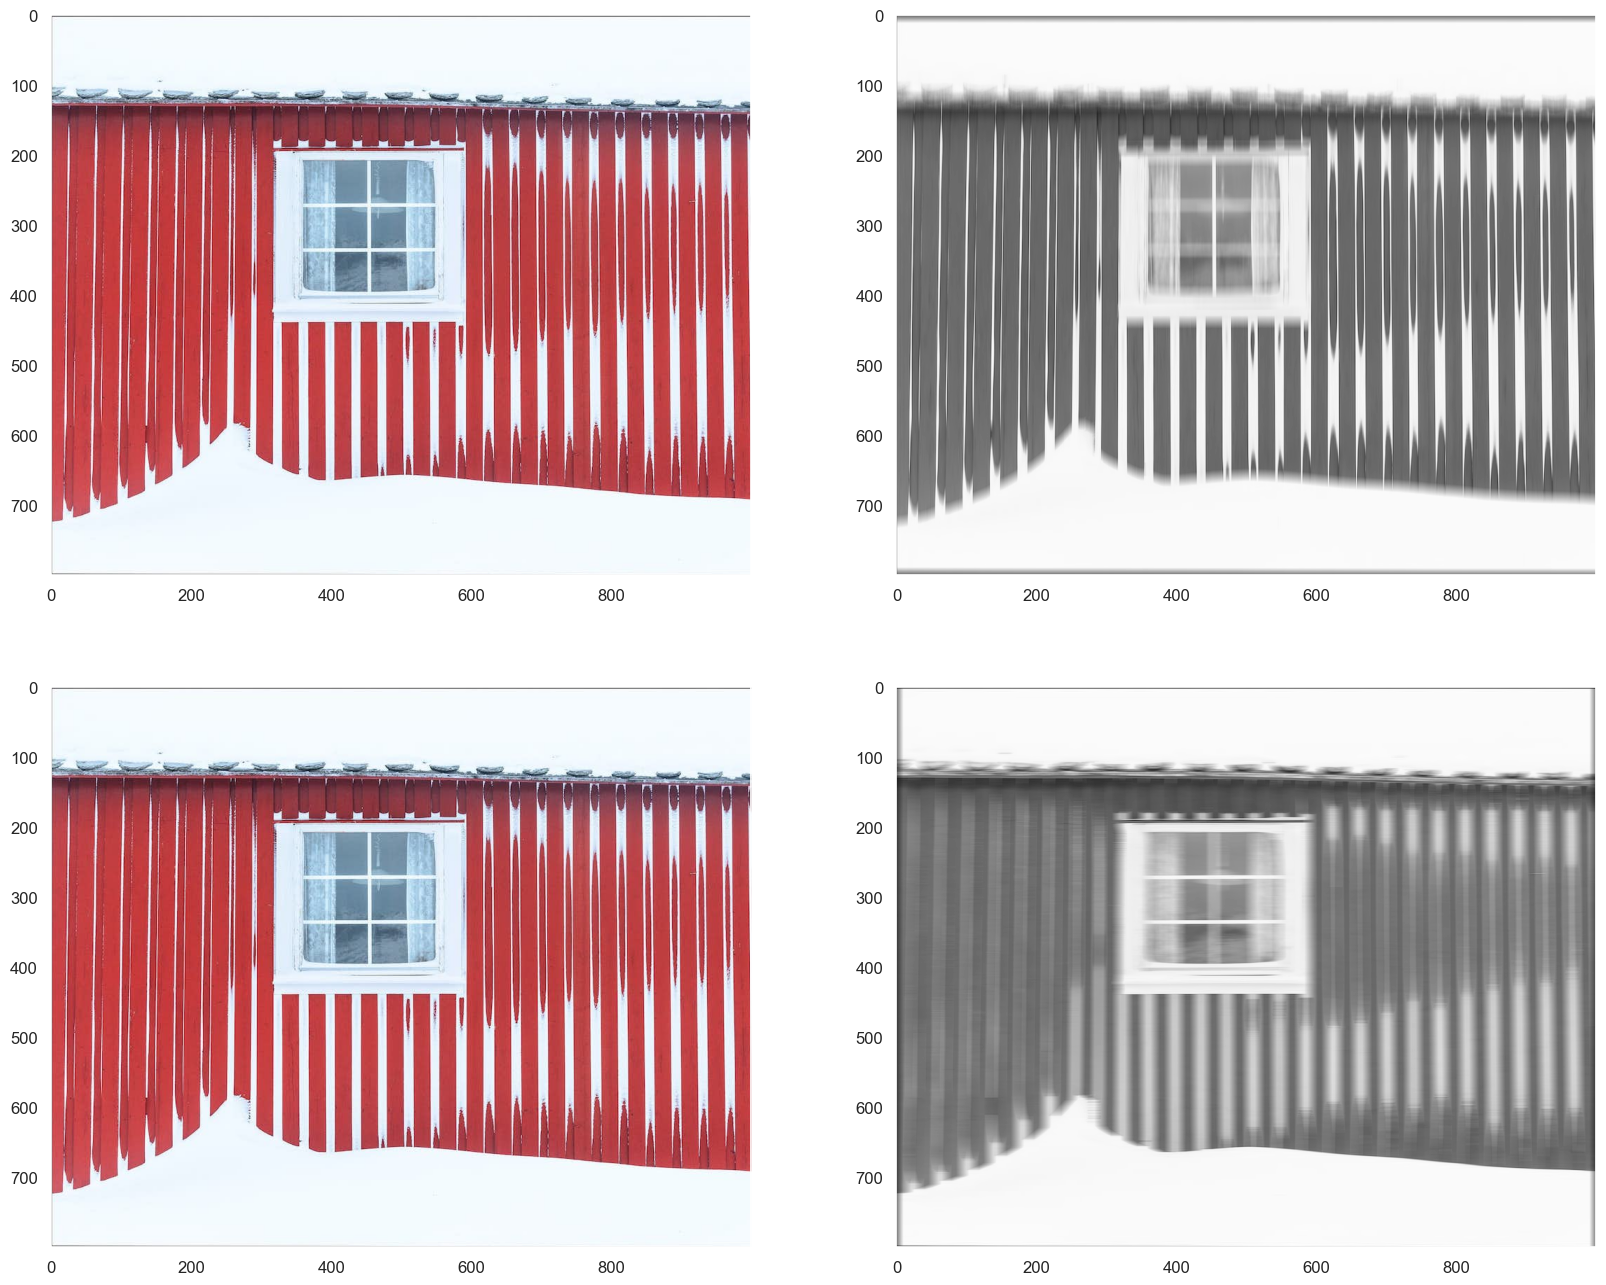

In [8]:
# Plot feature maps for second image
idx = 1
_, axs = plt.subplots(2, 2, figsize=(20, 16))
axs[0, 0].imshow(images[idx])
axs[1, 0].imshow(images[idx])
for i in (0, 1):
    axs[i, 1].imshow(outputs[idx, :, :, i], cmap='gray')

In [9]:
# Reapply the horizontal filter
filters = np.zeros(shape=(19, 19, 1, 1), dtype=np.float32)
filters[9, :, :, 0] = 1
images = np.array([outputs[i, :, :, 1] for i in (0, 1)])
images = images.reshape((2, 800, 1000, 1))
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME') 

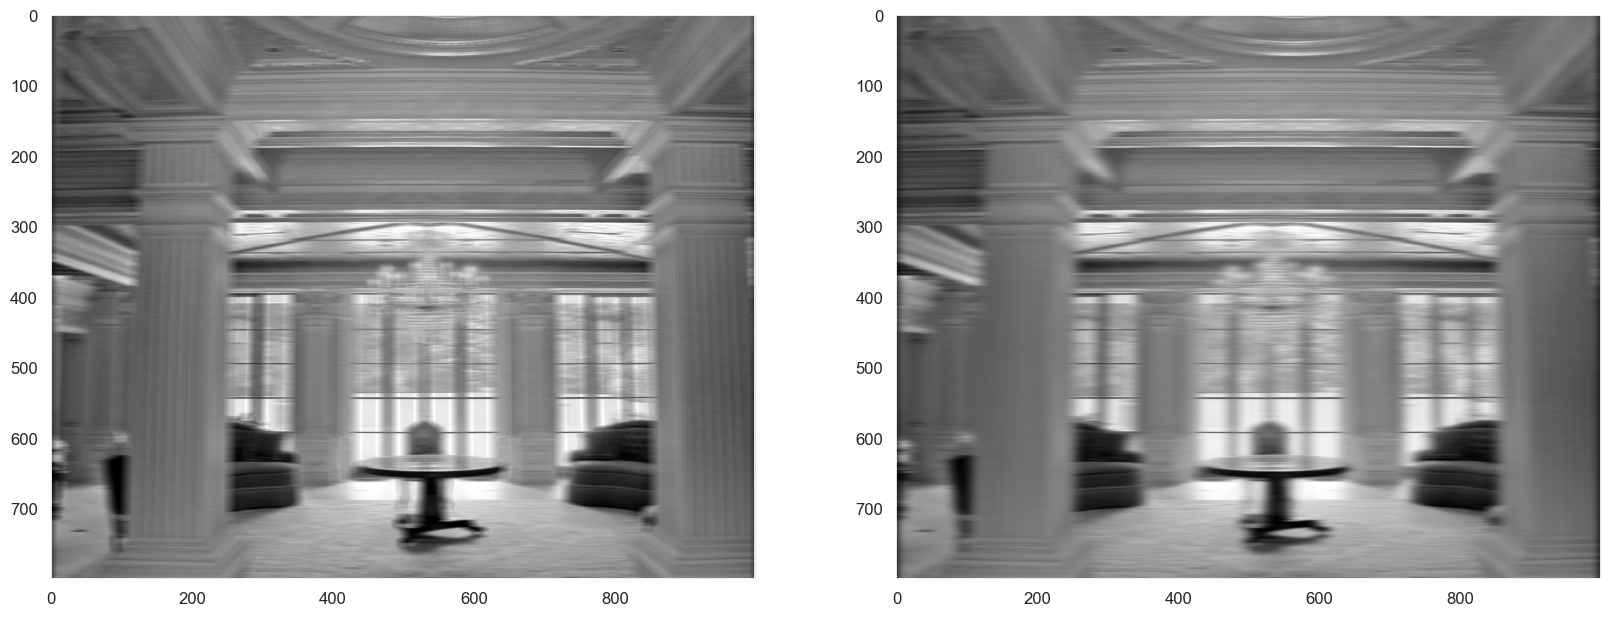

In [10]:
# Plot feature maps for first image after two horizontal filter passes
idx = 0
_, axs = plt.subplots(1, 2, figsize=(20, 16))
axs[0].imshow(images[idx], cmap='gray')
axs[1].imshow(outputs[idx, :, :, 0], cmap='gray')
plt.show()

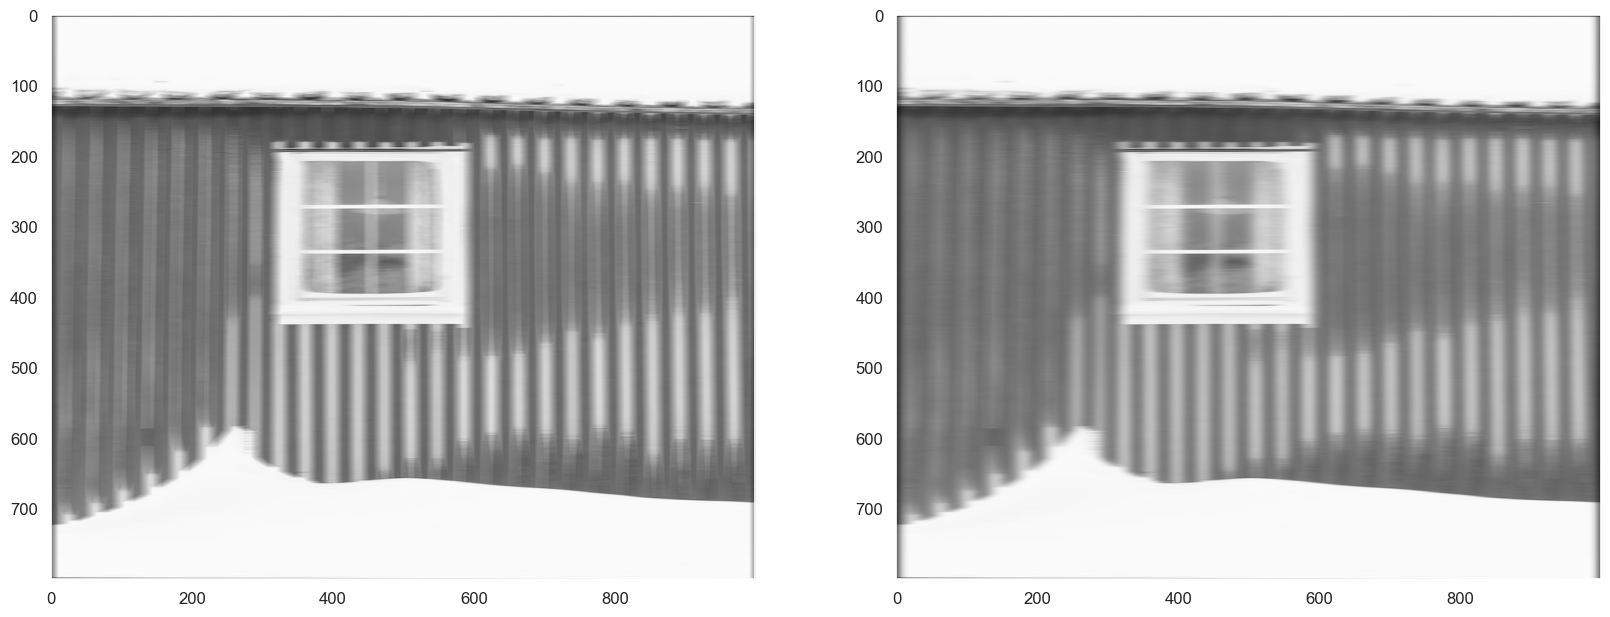

In [11]:
# Plot feature maps for second image after two horizontal filter passes
idx = 1
_, axs = plt.subplots(1, 2, figsize=(20, 16))
axs[0].imshow(images[idx], cmap='gray')
axs[1].imshow(outputs[idx, :, :, 0], cmap='gray')
plt.show()

## Example Convolutional Neural Network for Fashion MNIST

In [12]:
# Load fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist

((X_train_full, y_train_full),
    (X_test, y_test)) = fashion_mnist.load_data() 

X_valid = X_train_full[:5000] / 255.0
X_train = X_train_full[5000:] / 255.0
y_valid = y_train_full[:5000]
y_train = y_train_full[5000:]
X_test = X_test / 255.0 

class_names = [
    'T-Shirt or Top', 'Trouser', 'Pullover', 
    'Dress', 'Coat', 'Sandal', 'Shirt', 
    'Sneaker', 'Bag', 'Ankle Boot'
]

image_dims = (28, 28, 1)

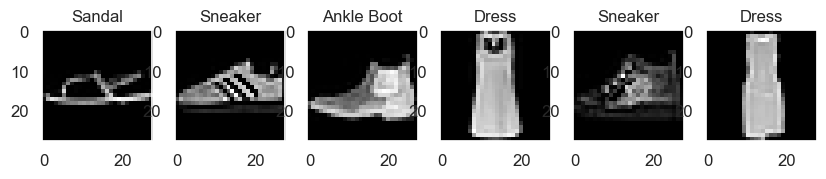

In [13]:
# Output random training instances as images
fig, ax = plt.subplots(1, 6, figsize=(10, 4))
locs = np.random.randint(0, 5000, 6)
for i, a in enumerate(ax):
    a.imshow(X_train[locs[i]], cmap='gray')
    a.set_title(class_names[y_train[locs[i]]])

plt.show()

In [14]:
# Define network
tf.keras.backend.clear_session()

model = keras.models.Sequential([ 
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', 
                        input_shape=image_dims),
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'), 
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'), 
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation='elu'), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(64, activation='elu'), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(len(class_names), activation='softmax')
]) 

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

In [16]:
# Fit the model
# This model takes a while to fit
X_train = X_train.reshape(*X_train.shape, 1)
X_valid = X_valid.reshape(*X_valid.shape, 1)

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/5


2023-03-14 17:26:23.571624: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1719/1719 [==============================] - 98s 57ms/step - loss: 0.5397 - accuracy: 0.8090 - val_loss: 0.2973 - val_accuracy: 0.8900
Epoch 2/5
1719/1719 [==============================] - 100s 58ms/step - loss: 0.3414 - accuracy: 0.8782 - val_loss: 0.2579 - val_accuracy: 0.9032
Epoch 3/5
1719/1719 [==============================] - 101s 59ms/step - loss: 0.2943 - accuracy: 0.8961 - val_loss: 0.2612 - val_accuracy: 0.9050
Epoch 4/5
1719/1719 [==============================] - 102s 59ms/step - loss: 0.2614 - accuracy: 0.9070 - val_loss: 0.2364 - val_accuracy: 0.9122
Epoch 5/5
1719/1719 [==============================] - 100s 58ms/step - loss: 0.2428 - accuracy: 0.9141 - val_loss: 0.2444 - val_accuracy: 0.9098


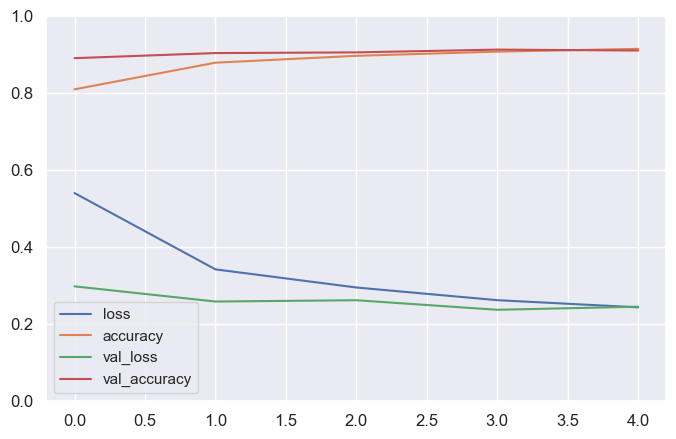

In [17]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [18]:
# Evaluate on the test data
# Note that this model outperforms the dense model we examined previously
X_test = X_test.reshape(*X_test.shape, 1)
model.evaluate(X_test, y_test)

313/313 [==============================] - 5s 17ms/step - loss: 0.2699 - accuracy: 0.9055


[0.26992976665496826, 0.9054999947547913]

## Exercise

Modify the learning rate for the Adam optimizer. Can you improve the learning process?